# ENGSCI762 Data Science Assignment

Develop a classifier for the California Housing dataset, which estimates the probability that the median house price of a specific district is larger or equal to USD500,000.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

## TASK 1 Define the label

-  Execute notebook `2_get_California_housing_data.ipynb` and download the California Housing dataset.
-  Write a function, which converts the continuous `median_house_value` into a class label, such that the label TRUE or 1 indicates a high priced district.
-  Amend the function `split_feature_labels()` (see below) from `4_prepare_California_housing.ipynb` by an optional parameter, which switches the output of the target from regression to classification  


In [2]:
def convert_median_house_value(housing):
    housing["median_house_value"] = housing["median_house_value"] >= 500000
    return housing

def split_features_labels(filename = '../data/train_set.csv', 
                          target_col='median_house_value',
                          classify=True):
    df = pd.read_csv(filename, index_col=0)
    
    if classify:
        df = convert_median_house_value(df)
       
    X = df.drop(target_col, axis=1)
    y = df[target_col].copy()
    
    return X, y

housing, housing_labels = split_features_labels(classify=True)
housing_test, housing_test_labels = split_features_labels('../data/test_set.csv', classify=True)

housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  16512.000000  16512.000000        16512.000000  16512.000000   
mean    -119.571981     35.634687           28.667696   2637.814801   
std        2.006763      2.138614           12.582749   2178.859507   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1453.000000   
50%     -118.490000     34.250000           29.000000   2127.000000   
75%     -118.007500     37.720000           37.000000   3150.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  
count    16344.000000  16512.000000  16512.000000   16512.000000  
mean       538.206804   1426.546875    499.568314       3.867417  
std        420.659688   1141.436888    380.887558       1.903056  
min          1.000000      3.000000      1.000000       0.499900  
25%        296.000000    786.000000    280.000000       2.560300  
50%        435.000000   1167.000000    410.000000       3.534800  
75%        647.250000   1728.250000    606.000000       4.739600  
max       6445.000000  35682.000000   6082.000000      15.000100

## TASK 2: Exploratory analysis

- If you randomly choose a feature vector from your training set: What is the probability that this feature vector describes a high priced district with `median_house_value`>= USD500,000.
- Develop a function `conddist`, which visualizes the conditional distribution of a specific features with respect to the class labels. (Tip: consider seaborn.distplot) 
- Visualize the spatial distribution of the high-priced districts only (ignoring the other districts).

In [3]:
housing_temp = pd.read_csv('../data/train_set.csv', index_col = 0)
housing_temp = convert_median_house_value(housing_temp)

sum(housing_temp["median_house_value"])/housing_temp['median_house_value'].count()

0.046875

4.7% chance the feature vector describes a high value district

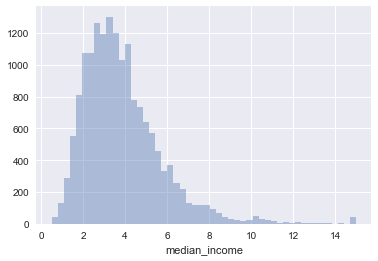

In [4]:
def conddist(feature):
    sns.distplot(feature, kde=False)
    plt.show()
    
conddist(housing_temp['median_income'])

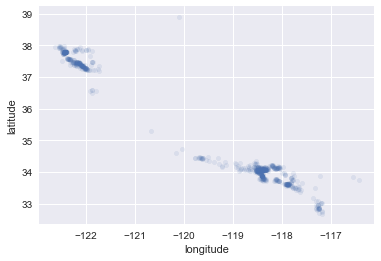

In [5]:
housing_copy = housing_temp.copy()
housing_copy.where(housing_copy['median_house_value'], inplace=True)
housing_copy.dropna(subset=['median_house_value'], inplace=True)
housing_copy.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

## TASK 3: Missing transformation

In notebook `3_explore_California_housing.ipynb` we had identified a useful transformation, which has not been implemented in `4_prepare_California_housing.ipynb`. 
* Amend the code of class `CombinedAttributesAdder` in order to include this transformation.
* Demonstrate that you're preparation pipeline has been successfully changed. 

### Temporarily remove categorical attribute

In [6]:
# Create DataFrame with numerical features
housing_num = housing.drop("ocean_proximity", axis=1)

### Define pipelines

In [7]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Imputer
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

class Binarizer(BaseEstimator, TransformerMixin):
    "Work around until CategoricalEncoder is in stable branch"
    def __init__(self):
        self.binarizer = LabelBinarizer()
    def fit(self, X, y=None):
        return self.binarizer.fit(X)
    def transform(self, X, y=None):
        return self.binarizer.transform(X)
    
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
        self.added_columns = ["rooms_per_household", "population_per_household", "log_population_per_household"]
        if self.add_bedrooms_per_room:
            self.added_columns += ["bedrooms_per_room"]
            
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        log_population_per_househould = np.log(population_per_household)
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, log_population_per_househould, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household, log_population_per_househould]
        
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

# Monkey-patch function returning feature names
all_num_columns = num_attribs + num_pipeline.named_steps['attribs_adder'].added_columns
num_pipeline.get_feature_names = lambda: all_num_columns

# Modify class by inheritance
cat_pipeline_steps = [
        ('selector', DataFrameSelector(cat_attribs)),
        ('label_encoder', Binarizer()),
    ]

class MyPipeline(Pipeline):
    def get_feature_names(self):
        return self.steps[1][1].binarizer.classes_
    
cat_pipeline = MyPipeline(cat_pipeline_steps)

preparation_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [8]:
X_train = pd.DataFrame(preparation_pipeline.fit_transform(housing),
                       columns=preparation_pipeline.get_feature_names(),
                       index = housing.index)
X_train.head()

num_pipeline__longitude  num_pipeline__latitude  \
1862                 -2.281365                2.887619   
18832                -1.668419                2.836182   
2488                 -0.387710                0.236288   
7637                  0.638850               -0.848560   
6941                  0.733532               -0.769067   

       num_pipeline__housing_median_age  num_pipeline__total_rooms  \
1862                          -0.927305                   0.292908   
18832                         -0.450447                   0.633004   
2488                          -1.563116                   0.015231   
7637                          -0.609400                   0.800987   
6941                           0.185363                  -0.767771   

       num_pipeline__total_bedrooms  num_pipeline__population  \
1862                       0.217002                  1.856885   
18832                      0.608756                  0.181753   
2488                       0.262388                  0.050336   
7637                       0.869129                  1.106054   
6941                      -0.764773                 -0.725026   

       num_pipeline__households  num_pipeline__median_income  \
1862                   0.224303                    -0.830593   
18832                  0.313571                    -0.793651   
2488                   0.108780                    -1.135007   
7637                   1.085476                    -0.225916   
6941                  -0.770771                    -0.602847   

       num_pipeline__rooms_per_household  \
1862                            0.060497   
18832                           0.402002   
2488                           -0.193990   
7637                           -0.246395   
6941                           -0.291004   

       num_pipeline__population_per_household  \
1862                                 0.255269   
18832                               -0.039779   
2488                                -0.030870   
7637                                -0.013438   
6941                                -0.016668   

       num_pipeline__log_population_per_household  \
1862                                     2.775788   
18832                                   -0.265156   
2488                                    -0.124698   
7637                                     0.135438   
6941                                     0.088602   

       num_pipeline__bedrooms_per_room  cat_pipeline__<1H OCEAN  \
1862                         -0.346868                      0.0   
18832                        -0.260680                      0.0   
2488                          0.450124                      0.0   
7637                         -0.128123                      1.0   
6941                          0.176319                      1.0   

       cat_pipeline__INLAND  cat_pipeline__ISLAND  cat_pipeline__NEAR BAY  \
1862                    0.0                   0.0                     0.0   
18832                   1.0                   0.0                     0.0   
2488                    1.0                   0.0                     0.0   
7637                    0.0                   0.0                     0.0   
6941                    0.0                   0.0                     0.0   

       cat_pipeline__NEAR OCEAN  
1862                        1.0  
18832                       0.0  
2488                        0.0  
7637                        0.0  
6941                        0.0

## TASK 4: Visualize new continuous features
* Use function `conddist` from Task 2 for visualizing the new continuous features.
* Discuss the diagrams

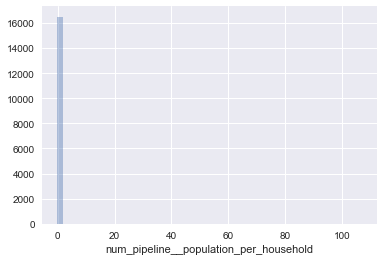

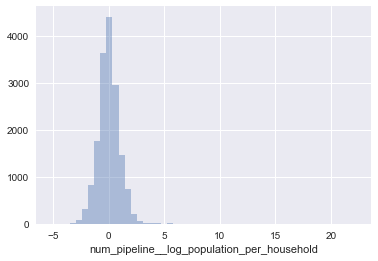

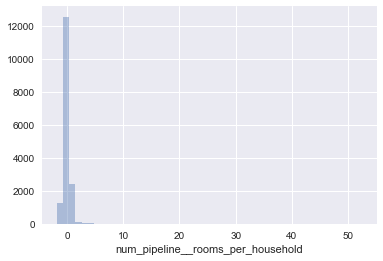

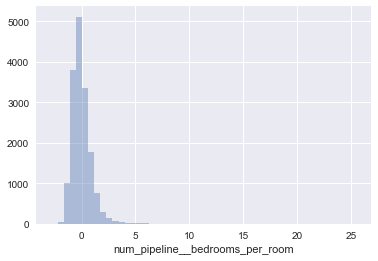

In [9]:
conddist(X_train['num_pipeline__population_per_household'])
conddist(X_train['num_pipeline__log_population_per_household'])
conddist(X_train['num_pipeline__rooms_per_household'])
conddist(X_train['num_pipeline__bedrooms_per_room'])

Population per household was not useful as expected: log population per household gives a much nicer spread to analyse.

Rooms per household is right-biased with low spread - this can be potentially powerful to predict value if the high value districts lie on the right side of the mean.

Bedrooms per room follows the same pattern as rooms per household and can be similarly potentially useful.


## TASK 5: Use clustering for the engineering of additional geo-spatial features

- Read the documentation of `sklearn.clustering.KMeans` and train a `KMeans`model with respect to `longitude` and `lattidue`.
- Visualize the predictions of KMeans.
- How do the predictions change for different values of parameter `n_clusters`? 

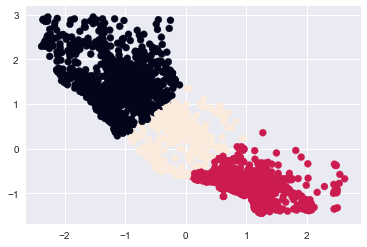

In [10]:
from sklearn.cluster import KMeans

n_clusters = 3

X_coord = np.c_[X_train['num_pipeline__longitude'], X_train['num_pipeline__latitude']]
y_pred = KMeans(n_clusters=n_clusters).fit_predict(X_coord)
plt.scatter(X_coord[:,0], X_coord[:,1], c=y_pred)

Increasing n_clusters increases the number of distinct groups the prediction can assign the district to.

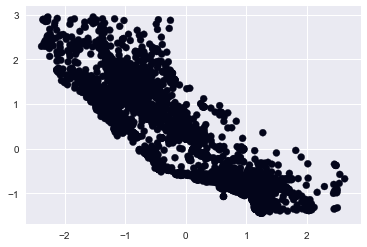

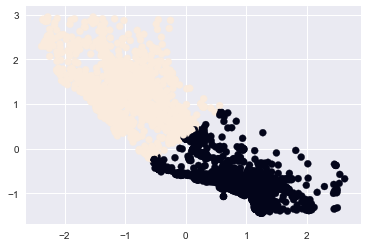

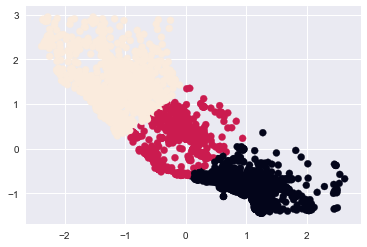

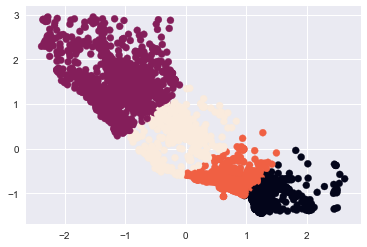

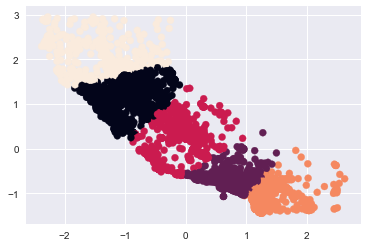

In [11]:
for i in range(5):
    X_coord = np.c_[X_train['num_pipeline__longitude'], X_train['num_pipeline__latitude']]
    y_pred = KMeans(n_clusters=i+1).fit_predict(X_coord)
    plt.scatter(X_coord[:,0], X_coord[:,1], c=y_pred)
    plt.show()

## TASK 6: Add the KMeans predictions to the preparation pipeline

* Develop an extended `preparation_pipeline`, which includes the geo-spatial information provided by `KMeans.fit_transform()`. 
* What is the interpretation of these features?

In [12]:
n_clusters = 8

In [13]:
# Modify class by inheritance
kmeans_pipeline_steps = [
        ('selector', DataFrameSelector(['longitude', 'latitude'])),
        ('clustering', KMeans(n_clusters = n_clusters)),
    ]

class KMyPipeline(Pipeline):
    def get_feature_names(self):
        return ['cluster_' + str(s) for s in range(n_clusters)]
    
kmeans_pipeline = KMyPipeline(kmeans_pipeline_steps)

preparation_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("geo_pipeline", kmeans_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

This adds new features with value equal to the distance from the cluster centres

In [14]:
X_train = pd.DataFrame(preparation_pipeline.fit_transform(housing),
                       columns=preparation_pipeline.get_feature_names(),
                       index = housing.index)
X_train.head()

num_pipeline__longitude  num_pipeline__latitude  \
1862                 -2.281365                2.887619   
18832                -1.668419                2.836182   
2488                 -0.387710                0.236288   
7637                  0.638850               -0.848560   
6941                  0.733532               -0.769067   

       num_pipeline__housing_median_age  num_pipeline__total_rooms  \
1862                          -0.927305                   0.292908   
18832                         -0.450447                   0.633004   
2488                          -1.563116                   0.015231   
7637                          -0.609400                   0.800987   
6941                           0.185363                  -0.767771   

       num_pipeline__total_bedrooms  num_pipeline__population  \
1862                       0.217002                  1.856885   
18832                      0.608756                  0.181753   
2488                       0.262388                  0.050336   
7637                       0.869129                  1.106054   
6941                      -0.764773                 -0.725026   

       num_pipeline__households  num_pipeline__median_income  \
1862                   0.224303                    -0.830593   
18832                  0.313571                    -0.793651   
2488                   0.108780                    -1.135007   
7637                   1.085476                    -0.225916   
6941                  -0.770771                    -0.602847   

       num_pipeline__rooms_per_household  \
1862                            0.060497   
18832                           0.402002   
2488                           -0.193990   
7637                           -0.246395   
6941                           -0.291004   

       num_pipeline__population_per_household            ...             \
1862                                 0.255269            ...              
18832                               -0.039779            ...              
2488                                -0.030870            ...              
7637                                -0.013438            ...              
6941                                -0.016668            ...              

       geo_pipeline__cluster_3  geo_pipeline__cluster_4  \
1862                 11.358154                 6.836953   
18832                10.527682                 6.006383   
2488                  4.615460                 0.867776   
7637                  1.568952                 3.149763   
6941                  1.507098                 3.088572   

       geo_pipeline__cluster_5  geo_pipeline__cluster_6  \
1862                  4.175098                 4.304655   
18832                 3.332074                 3.832858   
2488                  2.830242                 2.649876   
7637                  5.807493                 5.743681   
6941                  5.762181                 5.761355   

       geo_pipeline__cluster_7  cat_pipeline__<1H OCEAN  cat_pipeline__INLAND  \
1862                  8.312715                      0.0                   0.0   
18832                 7.609460                      0.0                   1.0   
2488                  1.489549                      0.0                   1.0   
7637                  1.668532                      1.0                   0.0   
6941                  1.730854                      1.0                   0.0   

       cat_pipeline__ISLAND  cat_pipeline__NEAR BAY  cat_pipeline__NEAR OCEAN  
1862                    0.0                     0.0                       1.0  
18832                   0.0                     0.0                       0.0  
2488                    0.0                     0.0                       0.0  
7637                    0.0                     0.0                       0.0  
6941                    0.0                     0.0                       0.0  

[5 rows x 25 columns]

## TASK 7: Evaluate different classifiers and select two

* Evaluate the accuracy of `LogisticRegression`, `DecisionTreeClassifier`, `AdaBoostClassifier`, `GradientBoostingClassifier`, and `RandomForestClassifier` with 10-fold cross-validation. 

- Discuss the most important features for the two best performing classifiers. Are the geo-spatial features relevant?

- Select the best performing classifier for the next task.

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

log_reg = LogisticRegression()
dec_cls = DecisionTreeClassifier()
adb_cls = AdaBoostClassifier()
grb_cls = GradientBoostingClassifier()
fst_cls = RandomForestClassifier()

In [16]:
from sklearn.model_selection import cross_val_score

y_train = housing_labels
cv_scores = lambda reg: cross_val_score(reg, X_train, np.ravel(y_train), scoring="f1", cv=10)

regressors = ['log_reg', 'dec_cls', 'adb_cls', 'grb_cls', 'fst_cls']

scores = dict([(var, cv_scores(globals()[var])) for var in regressors])
performance = pd.DataFrame(scores)
performance

adb_cls   dec_cls   fst_cls   grb_cls   log_reg
0  0.636364  0.526316  0.640000  0.685714  0.640625
1  0.558140  0.576687  0.645669  0.676259  0.587302
2  0.656716  0.622754  0.676692  0.724638  0.661417
3  0.592593  0.575163  0.682540  0.643357  0.652174
4  0.612903  0.594937  0.717557  0.636364  0.600000
5  0.676056  0.645570  0.755906  0.757576  0.619048
6  0.520325  0.537931  0.591304  0.624000  0.573770
7  0.629921  0.601399  0.661157  0.731343  0.611570
8  0.537815  0.523490  0.639344  0.629921  0.472727
9  0.584615  0.535948  0.676692  0.671429  0.619048

In [17]:
performance.aggregate(['mean', 'std'])

adb_cls   dec_cls   fst_cls  grb_cls   log_reg
mean  0.600545  0.574019  0.668686  0.67806  0.603768
std   0.051252  0.042519  0.045429  0.04669  0.053655

In [18]:
fst_cls.fit(X_train, np.ravel(y_train))
grb_cls.fit(X_train, np.ravel(y_train))

importance = pd.DataFrame(dict([(var, globals()[var].feature_importances_) 
                                for var in ['fst_cls', 'grb_cls']]),
                          index = X_train.columns)

importance.sort_values(by='grb_cls', ascending=False)

fst_cls   grb_cls
num_pipeline__median_income                 0.260784  0.248019
num_pipeline__rooms_per_household           0.056927  0.105957
num_pipeline__latitude                      0.041285  0.092884
geo_pipeline__cluster_6                     0.035544  0.062600
num_pipeline__population_per_household      0.047832  0.056373
geo_pipeline__cluster_5                     0.039450  0.055506
num_pipeline__log_population_per_household  0.045121  0.050909
geo_pipeline__cluster_7                     0.030297  0.050608
num_pipeline__housing_median_age            0.042569  0.044329
geo_pipeline__cluster_0                     0.032596  0.042089
num_pipeline__longitude                     0.037702  0.041056
geo_pipeline__cluster_1                     0.029710  0.030922
geo_pipeline__cluster_4                     0.040919  0.021302
cat_pipeline__NEAR OCEAN                    0.004624  0.015436
num_pipeline__population                    0.021226  0.012864
num_pipeline__households                    0.021794  0.012863
num_pipeline__bedrooms_per_room             0.090223  0.012206
num_pipeline__total_rooms                   0.025273  0.011665
geo_pipeline__cluster_3                     0.029858  0.009293
num_pipeline__total_bedrooms                0.019927  0.009288
geo_pipeline__cluster_2                     0.036306  0.007874
cat_pipeline__INLAND                        0.007045  0.005957
cat_pipeline__<1H OCEAN                     0.002103  0.000000
cat_pipeline__ISLAND                        0.000000  0.000000
cat_pipeline__NEAR BAY                      0.000886  0.000000

Median income is the most important feature, which makes sense and is fairly intuitive.
Next, rooms per household seems to be a good indicator as to the median price - also intuitive as size of house would be the underlying factor here.
The geospatial features are relevant as some are > 0.05. Removing num_pipeline__latitude/longitude would likely increase the feature relevance of the clustering features, as they are describing the same thing.

Best performing: gradient boosting.

## TASK 8: Fine-tune the hyper-parameters of the best classifiers from Task 7

* Select the best performing classifier from TASK 7 and fine-tune its hyper-parameters.

In [19]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=30, high=200),
        'max_features': randint(low=4, high=16),
        'max_depth': randint(low=1, high=5)
    }

rnd_search = RandomizedSearchCV(grb_cls, param_distributions=param_distribs,
                                n_iter=100, cv=10, scoring='f1',
                                n_jobs=4)
rnd_search.fit(X_train, np.ravel(y_train))
rnd_search.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=5, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=190,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [20]:
importance = pd.DataFrame({'importance': rnd_search.best_estimator_.feature_importances_},
                          index = X_train.columns)
importance.sort_values(ascending=False, by='importance')

importance
num_pipeline__median_income                   0.133795
num_pipeline__bedrooms_per_room               0.077043
num_pipeline__rooms_per_household             0.071680
num_pipeline__population_per_household        0.055988
geo_pipeline__cluster_7                       0.054095
num_pipeline__latitude                        0.054046
geo_pipeline__cluster_5                       0.051320
num_pipeline__log_population_per_household    0.049324
geo_pipeline__cluster_0                       0.048554
geo_pipeline__cluster_4                       0.046807
geo_pipeline__cluster_6                       0.043553
num_pipeline__population                      0.042593
num_pipeline__longitude                       0.035753
geo_pipeline__cluster_3                       0.035562
num_pipeline__housing_median_age              0.034200
geo_pipeline__cluster_1                       0.033015
geo_pipeline__cluster_2                       0.032642
num_pipeline__households                      0.029614
num_pipeline__total_rooms                     0.027859
num_pipeline__total_bedrooms                  0.025895
cat_pipeline__NEAR OCEAN                      0.006670
cat_pipeline__INLAND                          0.006093
cat_pipeline__NEAR BAY                        0.002717
cat_pipeline__<1H OCEAN                       0.001180
cat_pipeline__ISLAND                          0.000000

## TASK 9: Measure the performance of your model
    
* Evaluate your best model on the test set. 
* What is its accuracy? 
* Compare the result to the accuracy you would get from guessing.

In [21]:
from sklearn.metrics import accuracy_score

final_model = rnd_search.best_estimator_

X_test = pd.DataFrame(preparation_pipeline.fit_transform(housing_test),
                       columns=preparation_pipeline.get_feature_names(),
                       index = housing_test.index)

y_pred = final_model.predict(X_test)
print(accuracy_score(housing_test_labels, y_pred))

0.8837209302325582


0.046875 of the data set describes a high priced district (from task 2). If we simply guess all feature sets describe non-high priced districts, we can attain 95.3% accuracy.

The fitted classifier has a 88.4% accuracy. This is worse than simply guessing.


